In [1]:
from fastai.collab import *
from fastai.tabular import *

## Collaborative filtering example

`collab` models use data in a `DataFrame` of user, items, and ratings.

In [2]:
user,item,title = 'userId','movieId','title'

In [3]:
path = untar_data(URLs.ML_SAMPLE)
path

PosixPath('/Users/anuragsharma/.fastai/data/movie_lens_sample')

In [4]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


In [6]:
ratings.shape

(6031, 4)

That's all we need to create and train a model:

In [7]:
ratings.describe()

,userId,movieId,rating,timestamp
count,6031.000000,6031.000000,6031.000000,6.031000e+03
mean,350.269773,1892.725419,3.807826,1.127659e+09
std,194.409989,4483.290497,0.961857,1.591801e+08
min,15.000000,1.000000,0.500000,8.538928e+08
25%,176.000000,457.000000,3.000000,9.764243e+08
50%,358.000000,1089.000000,4.000000,1.111489e+09
75%,518.000000,2028.000000,4.500000,1.232810e+09
max,665.000000,58559.000000,5.000000,1.473804e+09


In [20]:
data = CollabDataBunch.from_df(ratings, seed=42)

In [21]:
y_range = [0,5.5]

In [22]:
learn = collab_learner(data, n_factors=50, y_range=y_range)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


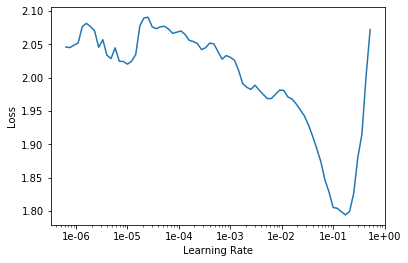

In [23]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [24]:
learn.fit_one_cycle(3, 5e-2)

epoch,train_loss,valid_loss,time
0,1.201086,1.265909,00:00
1,1.156087,1.190575,00:00
2,0.664826,1.035875,00:00


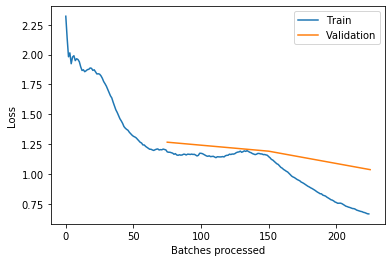

In [25]:
learn.recorder.plot_losses()

## Movielens 100k

Let's try with the full Movielens 100k data dataset, available from http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [26]:
path=Config.data_path()/'ml-100k'

In [27]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=[user,item,'rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [28]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [29]:
len(ratings)

100000

In [30]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [31]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title)

In [32]:
data.show_batch()

userId,title,target
230,Forrest Gump (1994),4.0
70,Snow White and the Seven Dwarfs (1937),4.0
42,Fearless (1993),2.0
205,Shadow Conspiracy (1997),1.0
704,Indian Summer (1996),4.0


In [33]:
y_range = [0,5.5]

In [34]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1, metrics=mean_squared_error)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


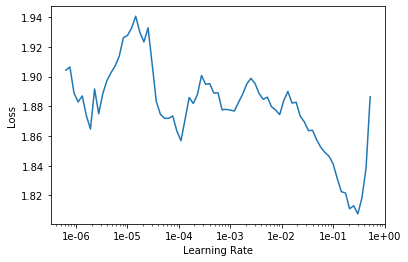

In [35]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [36]:
learn.fit_one_cycle(10, 5e-2)

epoch,train_loss,valid_loss,mean_squared_error,time
0,0.981541,0.969608,0.969608,00:07
1,1.350082,1.382359,1.382359,00:07
2,1.602537,1.725660,1.725659,00:12
3,1.592554,1.620031,1.620031,00:08
4,1.432660,1.463906,1.463906,00:07
5,1.245821,1.235443,1.235443,00:07
6,1.069857,1.055579,1.055578,00:06
7,0.897253,0.902702,0.902702,00:06
8,0.736370,0.829249,0.829249,00:08
9,0.533412,0.827169,0.827169,00:06


In [37]:
learn.save('dotprod')

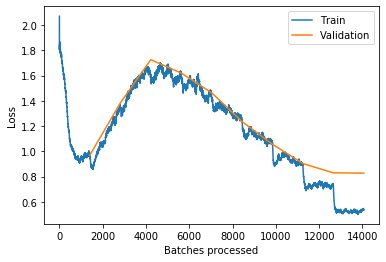

In [38]:
learn.recorder.plot_losses()

Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91, which corresponds to an MSE of `0.91**2 = 0.83`.

## Interpretation

### Setup

In [39]:
learn.load('dotprod');

In [40]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [41]:
g = rating_movie.groupby(title)['rating'].count()

In [42]:
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

### Movie bias

In [43]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [44]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [45]:
movie_ratings

[(tensor(0.7821), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.4869), 'Contact (1997)', 3.8035363457760316),
 (tensor(0.5876), 'Fargo (1996)', 4.155511811023622),
 (tensor(0.5546), 'Return of the Jedi (1983)', 4.007889546351085),
 (tensor(0.1167), 'Liar Liar (1997)', 3.156701030927835),
 (tensor(0.3059), 'English Patient, The (1996)', 3.656964656964657),
 (tensor(0.2588), 'Scream (1996)', 3.4414225941422596),
 (tensor(0.5094), 'Toy Story (1995)', 3.8783185840707963),
 (tensor(0.4038), 'Air Force One (1997)', 3.6310904872389793),
 (tensor(0.2590), 'Independence Day (ID4) (1996)', 3.438228438228438),
 (tensor(0.6849), 'Raiders of the Lost Ark (1981)', 4.252380952380952),
 (tensor(0.6971), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.5353), 'Pulp Fiction (1994)', 4.060913705583756),
 (tensor(0.4029), 'Twelve Monkeys (1995)', 3.798469387755102),
 (tensor(0.7243), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.3473), 'Jerry Maguire (1996)', 3.7109375),
 

In [46]:
item0 = lambda o:o[0]

In [47]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.6036),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.5017),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.4982), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.4455), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.4353), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.4287), 'Leave It to Beaver (1997)', 1.8409090909090908),
 (tensor(-0.4242), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.4088), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.4080), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.4012), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.4011), 'Grease 2 (1982)', 2.0),
 (tensor(-0.3977), 'Tales from the Hood (1995)', 2.037037037037037),
 (tensor(-0.3774), 'Showgirls (1995)', 1.9565217391304348),
 (tensor(-0.3761), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.3694), "Joe's Apart

In [48]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.8975), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.8457), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.7859), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.7821), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.7624), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.7504), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.7473), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.7301), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.7243), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.7183), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.7085), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.7047), 'Wrong Trousers, The (1993)', 4.466101694915254),
 (tensor(0.6971), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.6951), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.6931), 'Boot, Das (1981)', 4.203980099502488)]

### Movie weights

In [49]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [50]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [51]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [52]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.0672), 'Jungle2Jungle (1997)'),
 (tensor(1.0250), 'Congo (1995)'),
 (tensor(0.9126), 'Batman & Robin (1997)'),
 (tensor(0.8955), 'Relic, The (1997)'),
 (tensor(0.8843), 'Volcano (1997)'),
 (tensor(0.8706), "Dante's Peak (1997)"),
 (tensor(0.8664), 'First Knight (1995)'),
 (tensor(0.8530), 'Murder at 1600 (1997)'),
 (tensor(0.8327), 'D3: The Mighty Ducks (1996)'),
 (tensor(0.8227), 'Cutthroat Island (1995)')]

In [53]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.0064), 'Chinatown (1974)'),
 (tensor(-0.9847),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (tensor(-0.9447), 'Clockwork Orange, A (1971)'),
 (tensor(-0.9422), 'Apocalypse Now (1979)'),
 (tensor(-0.8997), 'Big Sleep, The (1946)'),
 (tensor(-0.8648), 'Casablanca (1942)'),
 (tensor(-0.8568), 'Delicatessen (1991)'),
 (tensor(-0.8501), '2001: A Space Odyssey (1968)'),
 (tensor(-0.8483), 'Ran (1985)'),
 (tensor(-0.8445), 'Taxi Driver (1976)')]

In [54]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [55]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.8186), 'Keys to Tulsa (1997)'),
 (tensor(0.7549), 'Lost Highway (1997)'),
 (tensor(0.7119), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(0.6994), 'Dead Man (1995)'),
 (tensor(0.6855), 'Beavis and Butt-head Do America (1996)'),
 (tensor(0.6830), 'Road to Wellville, The (1994)'),
 (tensor(0.6829), 'Very Brady Sequel, A (1996)'),
 (tensor(0.6776), 'Crash (1996)'),
 (tensor(0.6723), 'Cabin Boy (1994)'),
 (tensor(0.6680), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)')]

In [56]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.1909), 'Braveheart (1995)'),
 (tensor(-1.1832), 'Raiders of the Lost Ark (1981)'),
 (tensor(-0.9168), "It's a Wonderful Life (1946)"),
 (tensor(-0.9043), 'Forrest Gump (1994)'),
 (tensor(-0.8830), 'Titanic (1997)'),
 (tensor(-0.8705), 'Field of Dreams (1989)'),
 (tensor(-0.8640), 'Shawshank Redemption, The (1994)'),
 (tensor(-0.8417), 'Back to the Future (1985)'),
 (tensor(-0.8112), 'Star Wars (1977)'),
 (tensor(-0.8105), 'Return of the Jedi (1983)')]

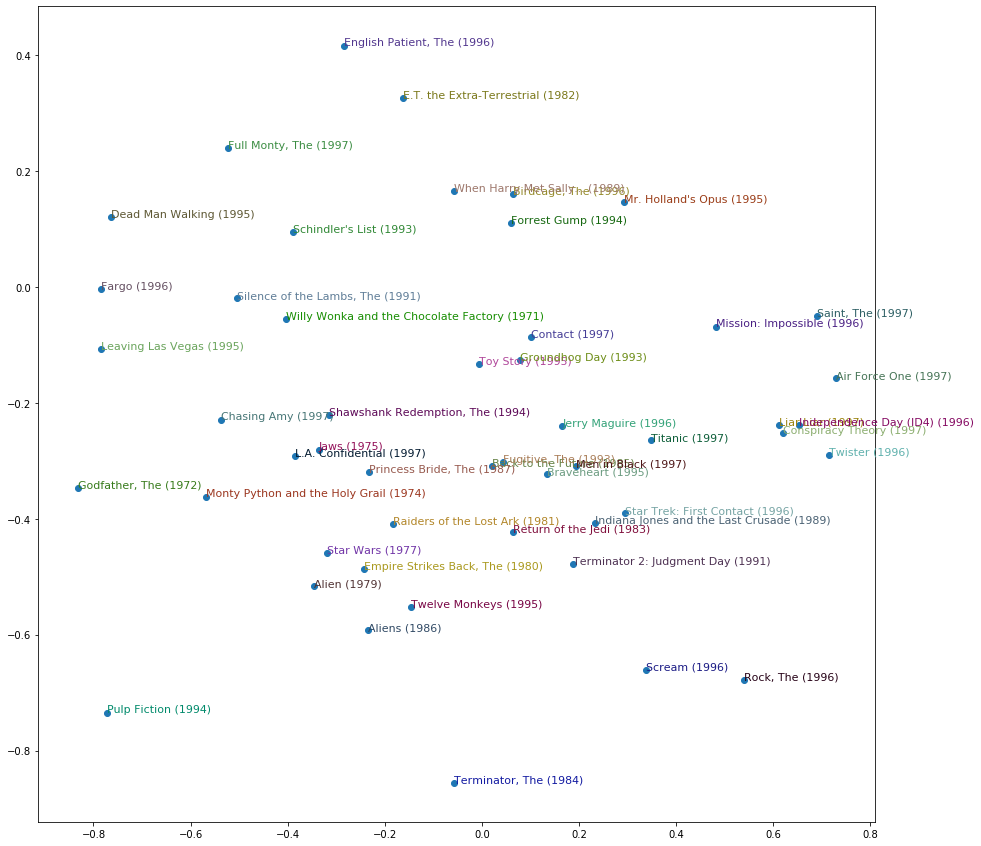

In [57]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()